### Imports

In [31]:
import importlib
from IPython.display import clear_output

%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import scipy.stats as stats
import keras
import keras.layers as layers
from keras import backend as K
import tensorflow as tf

import models

In [ ]:
K.tensorflow_backend._get_available_gpus()

In [ ]:
y_power = 6
n_y = 2**y_power

## Test a Distribution

<IPython.core.display.Javascript object>


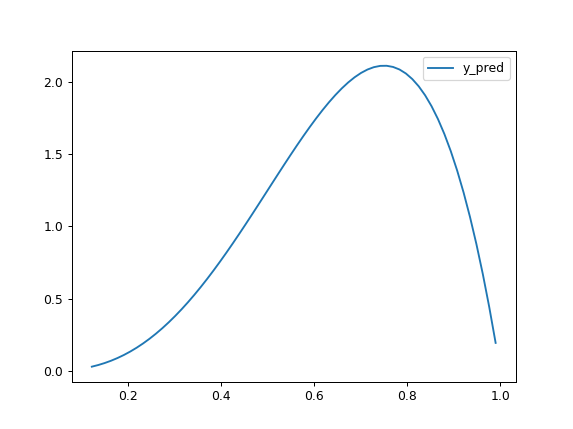

In [4]:
distribution = stats.beta
args = (4,2)
lim = (10**-3,10**-3)

y_x = np.linspace(distribution.ppf(lim[0], *args), distribution.ppf(1-lim[1], *args), n_y)
y = distribution.pdf(y_x, *args)
      
plt.figure()
plt.plot(y_x, y, label='y_pred')
plt.legend()

## Dataset

### Select Distributions

In [5]:
set_distributions = [stats.norm, stats.t, stats.powernorm, stats.beta]
arg_placeholders = [list(), (None,), (None,), (None, None)]

In [6]:
distributions = list()
abs_power_lim = -4
lims = list()
distrib_args = list()
n_type = 2**10
for i in range(n_type):
    for distribution, args_placeholder in zip(set_distributions,arg_placeholders):        
        successful = False
        while not successful:
            abs1 = 10 ** (np.random.random() * abs_power_lim)
            abs2 = 10 ** (np.random.random() * abs_power_lim)
            args = tuple(np.random.randint(1,10) for _ in args_placeholder)
            x_1 = distribution.ppf(abs1, *args)
            x_2 = distribution.ppf(1-abs2, *args)
            if x_1 > -5 and x_2 < 5:
                lims.append((abs1,abs2))
                distrib_args.append(args)
                distributions.append(distribution)
                successful = True

### Generate Curves

In [8]:
y_x = np.nan * np.ones((len(distributions),n_y))
y_pdf = np.nan * np.ones((len(distributions),n_y))
for i, distribution, args, lim in zip(range(len(distributions)),distributions,distrib_args, lims):
    y_x[i,:] = np.linspace(distribution.ppf(lim[0], *args), distribution.ppf(1-lim[1], *args), n_y)
    y = distribution.pdf(y_x[i,:], *args)
    y.reshape((1, y.size))    
    y_pdf[i,:] = y
    
n_x = list(set([ j * 2**i for i in range(1,y_power) for j in (2,3,5)]))
n_x = np.array(n_x)
n_x.sort()
x_x_list = list()
x_pdf_list = list()
y_list = list()
for n in n_x:  
    x_x = np.nan * np.ones((len(distributions),n))
    x_pdf = np.nan * np.ones((len(distributions),n))
    for i, distribution, args, lim in zip(range(len(distributions)),distributions,distrib_args, lims):
        x_x[i,:] = np.linspace(distribution.ppf(lim[0],*args), distribution.ppf(1-lim[1],*args), n) 
        x_pdf[i,:] = distribution.pdf(x_x[i,:],*args)
    x_x_list.append(x_x)
    x_pdf_list.append(x_pdf)

n_x: 6


<IPython.core.display.Javascript object>


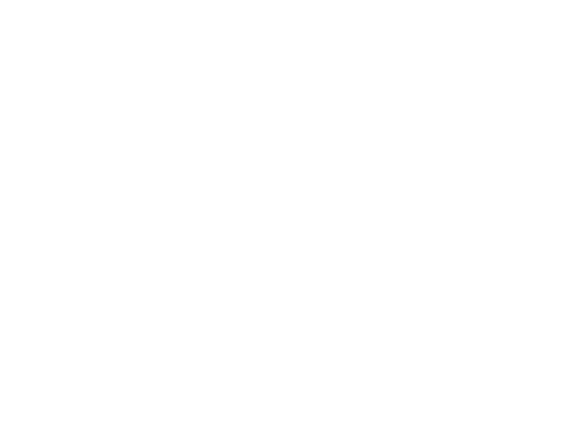

In [9]:
sample_index = 1
distribution_index = 210
print('n_x: {0}'.format(n_x[sample_index]))
plt.figure()
plt.plot(x_x_list[sample_index][distribution_index,:], 
         x_pdf_list[sample_index][distribution_index,:], label='x')
plt.plot(y_x[distribution_index,:], y_pdf[distribution_index,:], label='y')
plt.legend()

In [10]:
print('Individual Curves: {0}'.format(len(distributions)))
print('Total Curves:      {0}'.format(len(distributions)*len(n_x)))

Individual Curves: 4096
Total Curves:      61440


## Keras Model

In [13]:
keras.backend.clear_session()

n_a = 200

In [50]:
importlib.reload(models)

<module 'models' from 'F:\\Dev\\Python\\price_volatility_study\\models.py'>

In [51]:
model = models.output_feedback(n_a, n_y)
model.summary()

Feedback: 63 out of 64
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_43 (InputLayer)           (None, None, 1)      0                                            
__________________________________________________________________________________________________
input_44 (InputLayer)           (None, None, 1)      0                                            
__________________________________________________________________________________________________
concatenate_29 (Concatenate)    (None, None, 2)      0           input_43[0][0]                   
                                                                 input_44[0][0]                   
__________________________________________________________________________________________________
input_45 (InputLayer)           (None, 1, 400)       0                                

In [ ]:
model.load_weights('output_feedback_weights.h5')

In [ ]:
optim = keras.optimizers.Adam(lr=0.00025)
model.compile(optimizer=optim, loss='mean_squared_error', metrics=['accuracy'])

In [ ]:
decoder_in = np.zeros((x_pdf_list[0].shape[0],1,n_a*2))
rounds = 250
curve_sets = 45
for j in range(rounds):
    for i in range(len(x_pdf_list)):
        ranint = np.random.randint(0, len(x_pdf_list))
        x_pdf = x_pdf_list[ranint]
        x_x = x_x_list[ranint]
        clear_output()
        print('Round {0} out of {1}'.format(j+1, rounds))
        print('Set of Curves: {0} out of {1}  ==>  n_x: {2}'.format(i+1, curve_sets, x_x.shape[1]))
        x_pdf = x_pdf.reshape((x_pdf.shape[0],x_pdf.shape[1],1))
        x_x = x_x.reshape((x_x.shape[0], x_x.shape[1], 1))
        model.fit(x=[x_pdf, x_x, decoder_in], y=y_pdf, epochs=2, batch_size=512)
        
print('\n Completed!!')

## Test Model

In [ ]:
i = 130
distribution = distributions[i]
args = distrib_args[i]
lim = lims[i]
n = n_x[4]

x_x = np.linspace(distribution.ppf(lim[0],*args), distribution.ppf(1-lim[1],*args), n) 
x_pdf = distribution.pdf(x_x,*args)
y_x = np.linspace(distribution.ppf(lim[0],*args), distribution.ppf(1-lim[1],*args), n_y) 
y_pdf_true = distribution.pdf(y_x,*args)

decoder_in = np.zeros((x_pdf.shape[0],1,n_a*2))
x_pdf = x_pdf.reshape(1,x_pdf.size,1)
x_x = x_x.reshape(1, x_x.size, 1)
y_pdf_pred = model.predict(x=[x_pdf, x_x, decoder_in])

print('n_x: '+str(n))
plt.figure()
plt.plot(x_x.flatten(), x_pdf.flatten(), label='x')
plt.plot(y_x, y_pdf_pred.flatten(), label='y_pred')
plt.legend()

In [ ]:
distribution = stats.beta
args = (4,1)
lim = (10**-5,10**-5)
n = n_x[6]

x_x = np.linspace(distribution.ppf(lim[0],*args), distribution.ppf(1-lim[1],*args), n) 
x_pdf = distribution.pdf(x_x,*args)
y_x = np.linspace(distribution.ppf(lim[0],*args), distribution.ppf(1-lim[1],*args), n_y) 
y_pdf_true = distribution.pdf(y_x,*args)

decoder_in = np.zeros((x_pdf.shape[0],1,n_a*2))
x_pdf = x_pdf.reshape(1,x_pdf.size,1)
x_x = x_x.reshape(1,x_pdf.size,1)
y_pdf_pred = model.predict(x=[x_pdf, x_x, decoder_in])

plt.figure()
plt.plot(x_x.flatten(), x_pdf.flatten(), label='x')
plt.plot(y_x, y_pdf_pred.flatten(), label='y_pred')
plt.legend()

In [ ]:
model.save_weights('output_feedback_weights.h5')